In [130]:
import gzip
import numpy as np
import pandas as pd
import itertools

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# file of LINCS_function.py
import LINCS_functions as lf

# Core Code:

### Load in various mappings (perturbagen, signature, gene)

In [146]:
# construct gene_df
path = 'https://github.com/dhimmel/lincs/raw/gh-pages/data/geneinfo/geneinfo.tsv.gz'
gene_df = lf.url_to_df(path)
gene_df.head()

,pr_id,pr_gene_id,pr_gene_symbol,pr_gene_title,is_lm,is_l1000,is_bing,pr_pool_id
0,202938_x_at,100510314///100510451///27341///91695,NaN,NaN,False,True,False,inferred
1,204006_s_at,2214///2215,NaN,NaN,False,True,False,inferred
2,204060_s_at,5613///5616,NaN,NaN,False,True,False,inferred
3,204419_x_at,3047///3048,NaN,NaN,False,True,False,inferred
4,204438_at,414308///4360,NaN,NaN,False,True,False,inferred


In [9]:
# create list of bing and epi probes
is_bing = gene_df[gene_df.is_bing == True]
bing_list = list(is_bing.pr_id)
is_epi = gene_df[(gene_df.pr_pool_id == 'epsilon') | (gene_df.pr_pool_id == 'epsilon|deltap')]
epi_list = list(is_epi.pr_id)

In [145]:
# construct pert_df
path = 'https://github.com/dhimmel/lincs/raw/d42347fcb53c30afed705b973fb52a1ae45a26b1/data/pertinfo/pertinfo.tsv.gz'
pert_df = lf.url_to_df(path)
pert_df = pert_df[['pert_id', 'pubchem_cid']]
pert_df.rename(columns={'pubchem_cid':'pubchem_id'}, inplace=True)
pert_df.pubchem_id = pert_df['pubchem_id'].astype(str) # when merging frames later, easier to merge strings
pert_df.head()

,pert_id,pubchem_id
0,CSS001-ATTGCAT,nan
1,CSS001-GAGGATA,nan
2,CSS001-TCAATGA,nan
3,CSS001-TCAGTTC,nan
4,CSS001-TCCATCA,nan


In [135]:
# construct sig_df
path = 'https://github.com/dhimmel/lincs/raw/d42347fcb53c30afed705b973fb52a1ae45a26b1/data/siginfo/siginfo.tsv.gz'
sig_df = lf.url_to_df(path)
sig_df.head()

,sig_id,pert_id,pert_itime,distil_nsample,pert_idose,cell_id,pert_type,is_gold,distil_ss,ngenes_modulated_dn_lm,ngenes_modulated_up_lm
0,CVD001_HUH7_24H:BRD-A13020530-001-01-7:10,BRD-A13020530,24 h,1,10 µM,HUH7,trt_cp,False,13.82390,311,260
1,CVD001_HUH7_24H:BRD-K07762753-001-03-6:50,BRD-K07762753,24 h,2,50 µM,HUH7,trt_cp,True,14.55140,298,302
2,CPC004_PC3_6H:BRD-K34820100-001-02-1:10,BRD-K34820100,6 h,5,10 µM,PC3,trt_cp,False,4.15488,41,39
3,CPC004_PC3_6H:BRD-A22844106-001-16-1:10,BRD-A22844106,6 h,5,10 µM,PC3,trt_cp,False,2.93299,14,12
4,CPC004_PC3_6H:BRD-A55393291-001-05-7:10,BRD-A55393291,6 h,5,10 µM,PC3,trt_cp,False,1.96571,8,6


In [144]:
# construct drugbank_df
path = 'https://github.com/dhimmel/drugbank/raw/e8567eed2dd48ae0694a0960c518763a777845ff/data/mapping/pubchem.tsv'
drugbank_df = pd.read_table(path)
drugbank_df.pubchem_id = drugbank_df['pubchem_id'].astype(str)
drugbank_df.head()

,drugbank_id,pubchem_id
0,DB00014,11980055
1,DB00014,11981235
2,DB00014,11982741
3,DB00014,16052011
4,DB00014,23581804


## Expression Dataframe Construction (signature and perturbagen level)


In [159]:
# create dataframe with meta-data for perturbagens which map to drugbank drugs
db_meta_df = drugbank_df.merge(pert_df, how='inner').merge(sig_df[sig_df.is_gold == True], how='inner')
db_meta_df.head()

,drugbank_id,pubchem_id,pert_id,sig_id,pert_itime,distil_nsample,pert_idose,cell_id,pert_type,is_gold,distil_ss,ngenes_modulated_dn_lm,ngenes_modulated_up_lm
0,DB00014,23581804,BRD-A62434282,CPC010_MCF7_24H:BRD-A62434282-015-02-8:10,24 h,4,10 µM,MCF7,trt_cp,True,2.55441,10,12
1,DB00091,16404350,BRD-A38030642,CPC006_A375_24H:BRD-A38030642-001-02-0:10,24 h,5,10 µM,A375,trt_cp,True,2.79683,5,23
2,DB00091,16404350,BRD-A38030642,CPC001_PC3_24H:BRD-A38030642-001-01-2:10,24 h,6,10 µM,PC3,trt_cp,True,8.47970,169,134
3,DB00091,16404350,BRD-A38030642,CPC006_A549_24H:BRD-A38030642-001-02-0:10,24 h,3,10 µM,A549,trt_cp,True,4.60310,59,54
4,DB00091,16404350,BRD-A38030642,CPC006_HCC15_6H:BRD-A38030642-001-02-0:10,6 h,3,10 µM,HCC15,trt_cp,True,3.44276,19,21


In [172]:
# create signature (gold) expression dataframe

gold_sig = list(sig_df.sig_id[sig_df.is_gold == True & sig_df.pert_type.isin({'trt_cp', 'ctl_vehicle'})])
sig_expr_df = lf.extract_from_gctx(gctx_path, epi_list, gold_sig)

# Condense to perturbagens (pert_expr_df)
pert_to_sig_dic = {k: g['sig_id'].tolist() for k, g in sig_df.groupby('pert_id')}
pert_expr_df = lf.get_consensus_signatures(sig_expr_df, pert_to_sig_dic)

#Condense to drugbank drugs (db_expr_df)
db_to_sig_dic = {k: g['sig_id'].tolist() for k, g in db_meta_df.groupby('drugbank_id')}
db_expr_df = lf.get_consensus_signatures(sig_expr_df, db_to_sig_dic)

# Condense to genes
probe_to_gene = dict(zip(gene_df.pr_id, gene_df.pr_gene_id))
pert_expr_df = lf.probes_to_genes(pert_expr_df, probe_to_gene)
db_expr_df = lf.probes_to_genes(db_expr_df, probe_to_gene)

In [174]:
db_expr_df.head()

,DB00014,DB00091,DB00121,DB00130,DB00132,DB00136,DB00140,DB00146,DB00150,DB00154,...,DB08995,DB09002,DB09004,DB09009,DB09010,DB09015,DB09019,DB09020,DB09022,DB09023
10007,0.648519,-4.877796,-1.899073,-2.340979,-1.853676,-3.174554,-0.041754,-0.249993,0.054047,-3.041948,...,1.008031,0.338649,-0.024432,0.350294,-0.554042,-0.642456,-0.158549,3.518604,-0.040313,-1.620225
1001,-1.951535,2.527034,0.306370,0.493963,2.649402,1.512393,-0.947862,-0.034198,-0.626069,0.835866,...,-1.338539,0.856353,0.122878,-0.022722,0.448725,1.979185,0.417672,1.698260,1.451252,0.709389
10013,-0.132719,10.729866,0.953008,0.244222,-1.991589,-0.201201,-1.462436,-0.593725,0.521555,1.701095,...,1.155426,1.312049,0.476335,0.288325,-1.110906,-0.633362,-1.518177,-3.010489,-1.272537,1.908391
10038,1.057276,-2.106381,-1.185298,-2.472491,0.003451,0.248034,-0.784299,-2.274697,0.514062,-2.231416,...,0.113697,0.556341,0.722612,-3.061635,-0.640495,-0.623834,-0.372084,-9.318205,-0.623589,-0.333567
10046,0.555699,-0.396075,1.036692,-0.193256,1.161990,1.250674,-0.992345,0.351729,-0.632484,-0.337806,...,0.988284,0.550677,0.054936,1.973305,-0.634878,0.887162,0.584843,0.312912,-1.197322,-0.249682


In [48]:
pert_expr_df.head()

,BRD-A00100033,BRD-A00150179,BRD-A00267231,BRD-A00420644,BRD-A00474148,BRD-A00546892,BRD-A00626522,BRD-A00758722,BRD-A00827783,BRD-A00993607,...,BRD-U97083655,BRD2492+BRD3308,CMAP-AZD-1152HQPA,CMAP-C110766,CMAP-CRCGN-CB7992112,CMAP-ERGKD328,CMAP-PRISM-1B-NR,CMAP-PRISM-1B-PARENT,CMAP-PRISM-TP7,CMAP-T2DTUNICAMYCIN
10007,-0.065179,0.178658,-2.383586,2.186510,-0.704136,0.079153,0.156202,-1.657994,-0.472445,0.499677,...,-0.687548,-2.663140,2.365705,-1.286341,0.488223,-0.11000,-0.003293,-1.288858,-1.277398,1.662158
1001,3.696332,1.264003,2.685182,0.202994,3.314840,0.316016,-0.490717,-0.782547,0.265368,3.044513,...,1.372079,1.031615,1.408396,-0.986587,-1.173651,-0.79545,-1.124436,0.846463,0.507841,1.200578
10013,-1.700519,1.399285,0.739994,-4.654153,-0.462520,0.040457,-1.001534,-1.630009,-0.422672,-2.570210,...,0.069774,-1.257413,0.215515,-0.488952,1.064491,0.60665,-0.020142,-0.694764,-0.047448,-0.968385
10038,-0.155817,0.492447,-1.936597,-2.815903,0.713010,-1.509827,-1.481335,-2.850774,-0.635364,-2.440170,...,-1.549257,-6.439702,-4.990578,-1.354090,0.433419,-0.72665,-0.805497,-0.414906,-4.341555,0.551152
10046,-0.631788,-0.336569,-1.680068,2.550356,1.250462,-0.753669,1.961531,-0.562538,-0.524147,2.903087,...,1.065979,3.280520,0.081465,1.975714,0.180291,1.27680,1.084750,-0.481473,0.755581,1.327872


In [160]:
sig_expr_df.head()

,CVD001_HUH7_24H:BRD-K07762753-001-03-6:50,CPC004_VCAP_6H:BRD-A46393198-003-10-9:10,CPC005_VCAP_6H:BRD-A47494775-003-03-0:10,CPC005_VCAP_6H:BRD-A09925278-003-03-1:10,CPC005_VCAP_6H:BRD-A18419789-001-01-4:10,CPC005_VCAP_6H:BRD-A13133631-001-03-2:10,CPC005_VCAP_6H:BRD-A63998256-001-02-3:10,CPC005_VCAP_6H:BRD-A16700644-003-03-6:10,CPC005_VCAP_6H:BRD-A30435184-001-01-5:10,CPC005_VCAP_6H:BRD-A79672927-001-10-8:10,...,PCLB003_PC3_24H:BRD-A52530684-003-01-7:10,PCLB003_PC3_24H:BRD-A52530684-003-01-7:3.33,PCLB003_PC3_24H:BRD-A52530684-003-01-7:1.11,PCLB003_PC3_24H:BRD-A52530684-003-01-7:0.37,PCLB003_PC3_24H:BRD-A52530684-003-01-7:0.12,PCLB003_PC3_24H:BRD-A52530684-003-01-7:0.04,PCLB003_PC3_24H:BRD-A75409952-001-01-6:10,PCLB003_PC3_24H:BRD-A75409952-001-01-6:1.11,PCLB003_PC3_24H:BRD-A75409952-001-01-6:0.37,PCLB003_PC3_24H:BRD-A75409952-001-01-6:0.12
10007,-3.03035,-0.797946,-1.319706,0.208536,0.773206,0.207783,0.252518,0.874929,-0.144667,-2.473639,...,2.252964,-2.291814,-1.873145,-1.643601,-1.582375,-1.149185,-0.777056,-0.360035,-0.779908,0.547772
1001,5.98865,0.107966,-0.071966,0.549601,-0.435838,-0.341596,0.737641,-0.057256,-0.504064,-0.208501,...,4.974200,-0.573330,2.050377,2.510575,-0.406503,-0.223124,-0.519643,0.936064,-0.360450,-1.135321
10013,1.06710,0.690852,0.445116,0.854740,-0.036292,-0.078481,-0.604483,-0.228629,0.700390,-0.069632,...,2.597796,0.731264,0.807062,0.433304,0.994488,0.351367,1.484245,0.591640,0.510227,-0.428541
10038,0.64205,-1.071280,-0.502718,0.071236,1.175386,-0.070663,-0.042558,-0.506186,0.282718,0.521387,...,-9.999999,-5.140641,-2.325545,-4.991435,-1.376771,-0.598156,-3.355354,0.527003,-3.223390,-0.227505
10046,0.24075,5.825535,0.114796,0.059502,-0.431986,-0.217563,-0.316749,-0.103192,-0.233507,0.041944,...,2.925957,-0.500092,0.445234,1.358848,0.007913,0.211099,-1.015954,-0.328821,0.013441,-1.221373


In [49]:
# SAVE pert_expr_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/pert_expr_df.csv.gz"
with gzip.open(path, "w") as writefile:
    pert_expr_df.to_csv(writefile, sep='\t')

In [51]:
# SAVE sig_expr_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/sig_expr_df.csv.gz"
with gzip.open(path, "w") as writefile:
    sig_expr_df.to_csv(writefile, sep='\t')

In [175]:
# SAVE db_expr_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/db_expr_df.csv.gz"
with gzip.open(path, "w") as writefile:
    db_expr_df.to_csv(writefile, sep='\t')

In [ ]:
# LOAD pert_expr_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/pert_expr_df.csv.gz"
with gzip.open(path, "r") as readfile:
    pert_expr_df = pd.DataFrame.from_csv(readfile, sep='\t', index_col=[0,1])

In [21]:
# LOAD sig_expr_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/sig_expr_df.csv.gz"
with gzip.open(path, "r") as readfile:
    sig_expr_df = pd.DataFrame.from_csv(readfile, sep='\t', index_col=[0,1])

In [ ]:
# LOAD db_expr_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/db_expr_df.csv.gz"
with gzip.open(path, "r") as readfile:
    db_expr_df = pd.DataFrame.from_csv(readfile, sep='\t', index_col=[0,1])

## Indications

In [149]:
# Load in indication to drugbank drug mapping
path = "https://github.com/dhimmel/indications/raw/36f0c5f143618abbbf8c9eb94b7318cb5936fd61/data/indications.tsv"
indication_df = pd.read_table(path)
indication_df = indication_df[indication_df.confidence == "high"]
indication_df = pd.merge(indication_df, drugbank_df, how='inner').merge(pert_df, how='inner')
indication_df.head()

,doid_code,drugbank_id,doid_name,drugbank_name,n_hc_resources,n_lc_resources,confidence,pubchem_id,pert_id
0,DOID:0050425,DB00190,restless legs syndrome,Carbidopa,1,0,high,2563,BRD-A69512159
1,DOID:10652,DB00190,Alzheimer's disease,Carbidopa,1,0,high,2563,BRD-A69512159
2,DOID:14330,DB00190,Parkinson's disease,Carbidopa,3,0,high,2563,BRD-A69512159
3,DOID:0050425,DB00190,restless legs syndrome,Carbidopa,1,0,high,34359,BRD-K78712176
4,DOID:10652,DB00190,Alzheimer's disease,Carbidopa,1,0,high,34359,BRD-K78712176


In [96]:
# SAVE indication_df
path = "/Users/leobrueggeman/GitHub/LINCS_repo/consensus_expression_dataframes/indication_df.tsv"
with open(path, "w") as writefile:
    indication_df.to_csv(writefile, sep='\t')

# Visualizations and Non-Core Code

### Number of significant genes in gold, control, and non-gold signatures

In [176]:
path = 'https://github.com/dhimmel/lincs/raw/d42347fcb53c30afed705b973fb52a1ae45a26b1/data/siginfo/siginfo.tsv.gz'
sig_df = url_to_df(path)
sig_df = sig_df[sig_df.pert_type.isin(['trt_cp','ctl_vehicle'])]

gold_df = sig_df[sig_df.is_gold == True]
control_df = sig_df[sig_df.pert_id.isin(['H20', 'DMSO', 'PBS'])]
non_gold_df = sig_df[sig_df.is_gold == False]
non_gold_df = non_gold_df[-non_gold_df.pert_id.isin(['H20', 'DMSO', 'PBS'])]

gold_df.reset_index(inplace=True, drop=True)
control_df.reset_index(inplace=True, drop=True)
non_gold_df.reset_index(inplace=True, drop=True)

gold_df['classes'] = 'gold sig'
control_df['classes'] = 'control sig'
non_gold_df['classes'] = 'non-gold sig' 
gold_df['genes'] = gold_df.ngenes_modulated_dn_lm + gold_df.ngenes_modulated_up_lm
control_df['genes'] = control_df.ngenes_modulated_dn_lm + control_df.ngenes_modulated_up_lm
non_gold_df['genes'] = non_gold_df.ngenes_modulated_dn_lm + non_gold_df.ngenes_modulated_up_lm

gold_df = gold_df[['classes', 'genes']]
control_df = control_df[['classes', 'genes']]
non_gold_df = non_gold_df[['classes', 'genes']]

gold_df.genes = gold_df.genes.astype(float)
control_df.genes = control_df.genes.astype(float)
non_gold_df.genes = non_gold_df.genes.astype(float)



/Users/leobrueggeman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leobrueggeman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/leobrueggeman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documen

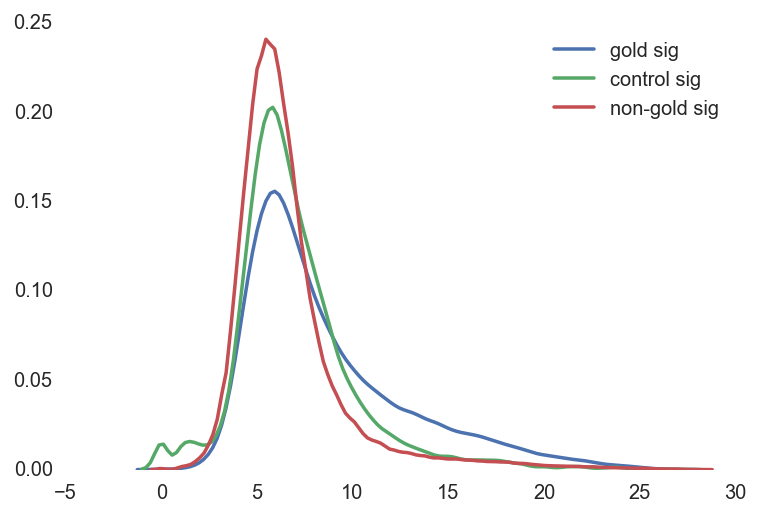

In [177]:
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
sns.kdeplot(gold_df.genes.apply(np.sqrt), label = 'gold sig')
sns.kdeplot(control_df.genes.apply(np.sqrt), label = 'control sig')
sns.kdeplot(non_gold_df.genes.apply(np.sqrt), label = 'non-gold sig')